In [3]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

In [5]:
# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.


In [6]:
# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

In [7]:
# For evaluating our model's performance
import sklearn.metrics as m

In [8]:
# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [10]:
# read in the data file 
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

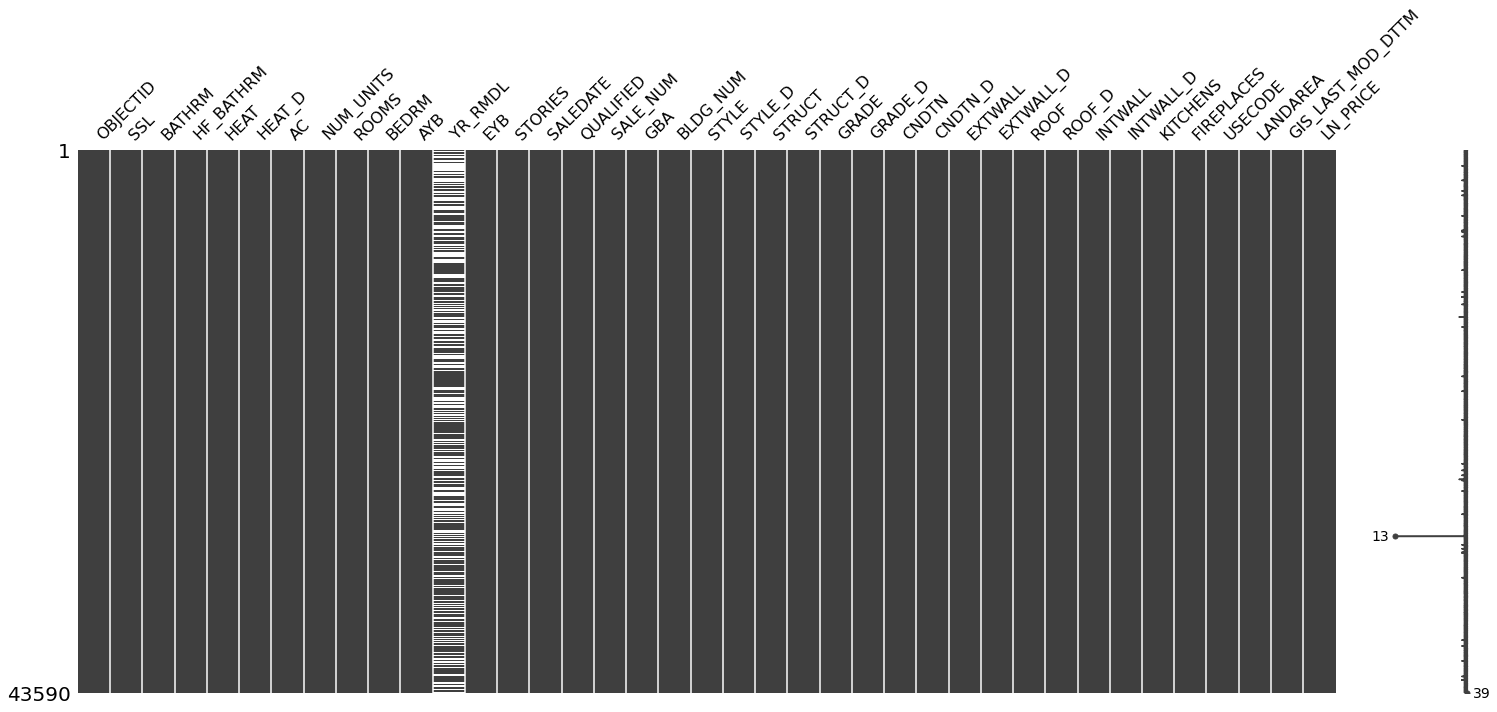

In [11]:
# look at the missing values 
miss.matrix(train)

#### So the missing values are in the column YR_RMDL, which is defined as last year residence remodeled 

In [65]:
# drop the observations where the outcome variable is missing (both training and test)
train = train[~train.LN_PRICE.isna()]
test = test[~test.LN_PRICE.isna()]

# Keep the observations where the log price is larger than 0 only 
train = train[train.LN_PRICE > 0]
test = test[test.LN_PRICE > 0]

# drop the missing values remaining 
train = train.dropna()
test = test.dropna()

In [16]:
# get the outcome variable 
train_y = train["LN_PRICE"]

In [36]:
# get the predictors 
train_x = train[['BATHRM','ROOMS','BEDRM','AC','LANDAREA','KITCHENS','FIREPLACES','GBA']]

In [37]:
# check the missing values for the predictors 
train_x.isnull().sum()

BATHRM        0
ROOMS         0
BEDRM         0
AC            0
LANDAREA      0
KITCHENS      0
FIREPLACES    0
GBA           0
dtype: int64

#### Now, in our X and Y, there is no missing value 

### Pre-processing

In [42]:
# Change AC from Y or N to 1 or 0
train_x["AC"] = np.where(train_x["AC"] == "Y", 1, 0)

In [39]:
# log the landarea
train_x['LANDAREA'] = np.log(train_x['LANDAREA'])

In [43]:
scaler = pp.MinMaxScaler()
col_names = list(train_x)
train_x = scaler.fit_transform(train_x)

In [44]:
# convert to data frame 
train_x = pd.DataFrame(train_x,columns=col_names)

In [45]:
# head 
train_x.head()

,BATHRM,ROOMS,BEDRM,AC,LANDAREA,KITCHENS,FIREPLACES,GBA
0,0.272727,0.300000,0.074074,1.0,0.354963,0.022727,0.000000,0.055050
1,0.181818,0.300000,0.074074,1.0,0.546214,0.022727,0.076923,0.120232
2,0.181818,0.366667,0.074074,0.0,0.345348,0.022727,0.000000,0.163214
3,0.272727,0.233333,0.074074,1.0,0.365790,0.022727,0.076923,0.062665
4,0.272727,0.233333,0.055556,1.0,0.279556,0.045455,0.000000,0.084221


### Modeling 
- Linear Regression 
- KNN
- Decision Trees
- Bagging
- Random Fores 

In [47]:
# set the folds 
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# set the metrics for scoring 
use_metrics = ["neg_mean_squared_error"]

### Linear Model 

In [49]:
lm_scores = cross_validate(LM(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

### KNN

In [51]:
knn_scores = cross_validate(KNN(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

### Decision Trees 


In [53]:
dt_scores = cross_validate(DTree(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

### Bagging 

In [54]:
bag_scores = cross_validate(Bag(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

### Random Forest 

In [55]:
rf_scores = cross_validate(RF(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

In [56]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.384543
1,lm,0.376871
2,lm,0.396990
3,lm,0.394915
4,lm,0.363387
5,knn,0.422274
6,knn,0.399606
7,knn,0.420998
8,knn,0.417299
9,knn,0.398186


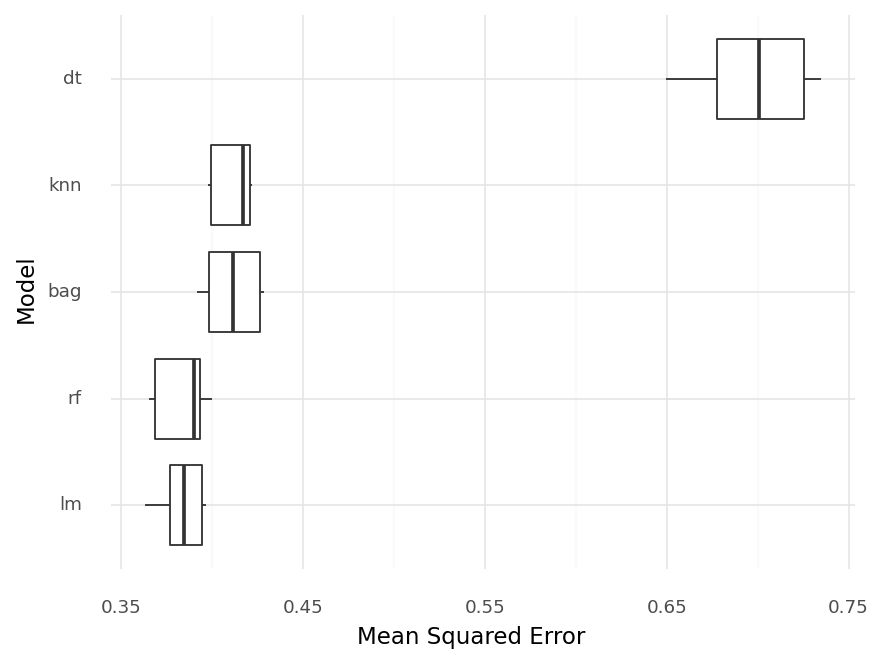

<ggplot: (8761592377351)>

In [57]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

#### Lower MSE is better. SO the linear model is the best 

### Tuning

In [62]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM','ROOMS','BEDRM','AC','LANDAREA','KITCHENS','FIREPLACES','GBA'])])

# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30,40,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]

# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'ROOMS',
                                                                          'BEDRM',
                                                                          'AC',
                                                                          'LANDAREA',
                                                                          'KITCHENS',
                                                                          'FIREPLACES',
                                                                          'GBA'])])),
                                 

In [63]:
# look at the best fit score from the scan.
search.best_score_

-0.3597433093073447

In [64]:
# Look at the best model
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=50), 'model__n_neighbors': 50}

### Test Performance 

In [67]:
# set the the X and Y 
test_x = test[['BATHRM','ROOMS','BEDRM','AC','LANDAREA','KITCHENS','FIREPLACES','GBA']]
test_y = test['LN_PRICE']

# Change AC from Y or N to 1 or 0
test_x["AC"] = np.where(test_x["AC"] == "Y", 1, 0)

In [68]:
scaler = pp.MinMaxScaler()
col_names = list(test_x)
test_x = scaler.fit_transform(test_x)

In [70]:
# convert to data frame
test_x = pd.DataFrame(test_x,columns=col_names)

In [71]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_x)

In [72]:
m.mean_squared_error(test_y,pred_y)

0.44652091923654025

In [73]:
m.r2_score(test_y,pred_y)

0.2631729517835343

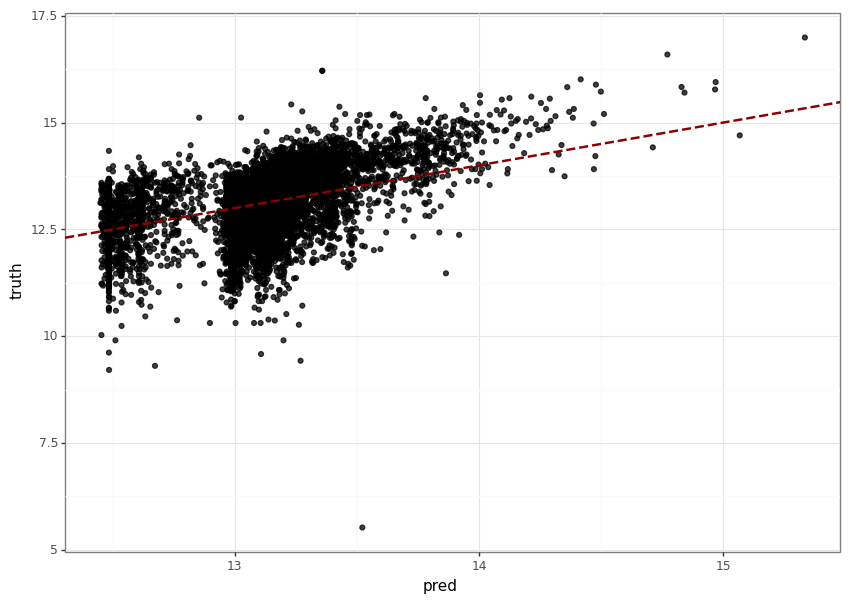

<ggplot: (8761631020978)>

In [74]:
# visualize
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)